In [2]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np

from tqdm import notebook
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
device = torch.device("cpu")

In [1]:
from extensions_utils import cube

In [4]:
DATA_FOLDER = os.path.join('data', 'meshes', 'non-smooth')
def locate_mesh(name:str):
    return os.path.join(DATA_FOLDER, name)

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [12]:
def deform_mesh(src_mesh, trg_mesh, steps=2000, wc=1.0, we=0, wn=0, wl=0, plot_period=500):
    # We will learn to deform the source mesh by offsetting its vertices
    # The shape of the deform parameters is equal to the total number of vertices in src_mesh
    deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
    # The optimizer
    optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

    # Number of optimization steps
    Niter = steps
    # Weight for the chamfer loss
    w_chamfer = wc 
    # Weight for mesh edge loss
    w_edge = we 
    # Weight for mesh normal consistency
    w_normal = wn
    # Weight for mesh laplacian smoothing
    w_laplacian = wl 
    # Plot period for the losses
    plot_period = plot_period
    loop = notebook.tqdm(range(Niter))

    chamfer_losses = []
    laplacian_losses = []
    edge_losses = []
    normal_losses = []

    %matplotlib inline

    for i in loop:
        # Initialize optimizer
        optimizer.zero_grad()

        # Deform the mesh
        new_src_mesh = src_mesh.offset_verts(deform_verts)

        # We sample 5k points from the surface of each mesh 
        sample_trg = sample_points_from_meshes(trg_mesh, 5000)
        sample_src = sample_points_from_meshes(new_src_mesh, 5000)

        # We compare the two sets of pointclouds by computing (a) the chamfer loss
        loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

        # and (b) the edge length of the predicted mesh
        loss_edge = mesh_edge_loss(new_src_mesh)

        # mesh normal consistency
        loss_normal = mesh_normal_consistency(new_src_mesh)

        # mesh laplacian smoothing
        loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

        # Weighted sum of the losses
        loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

        # Print the losses
        loop.set_description('total_loss = %.6f' % loss)

        # Save the losses for plotting
        chamfer_losses.append(loss_chamfer)
        edge_losses.append(loss_edge)
        normal_losses.append(loss_normal)
        laplacian_losses.append(loss_laplacian)

        # Plot mesh
        if i % plot_period == 0:
            plot_pointcloud(new_src_mesh, title="iter: %d" % i)

        # Optimization step
        loss.backward()
        optimizer.step()
    
    print('Weights:\n Chamfer: {} | Edge: {} | Normal: {} | Laplacian: {}'.format(wc, we, wn, wl))    
    # Visualize Loss
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    ax.plot(chamfer_losses, label="chamfer loss")
    ax.plot(edge_losses, label="edge loss")
    ax.plot(normal_losses, label="normal loss")
    ax.plot(laplacian_losses, label="laplacian loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")
    plt.show()

    
    return new_src_mesh

def save_mesh(mesh, path):
    # Fetch the verts and faces of the final predicted mesh
    final_verts, final_faces = mesh.get_mesh_verts_faces(0)
    
    # Store the predicted mesh using save_obj
    final_obj = locate_mesh(path)
    save_obj(final_obj, final_verts, final_faces)

In [13]:
pairs = [(cube(i), cube(i)) for i in range(4)]

level 0 cubes


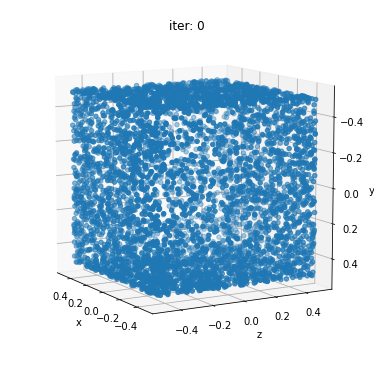

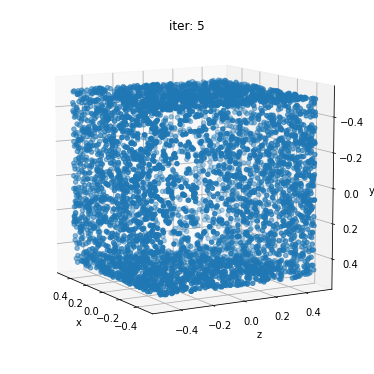

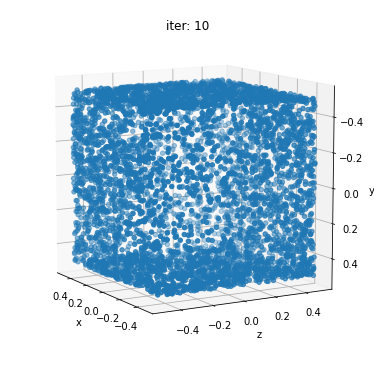

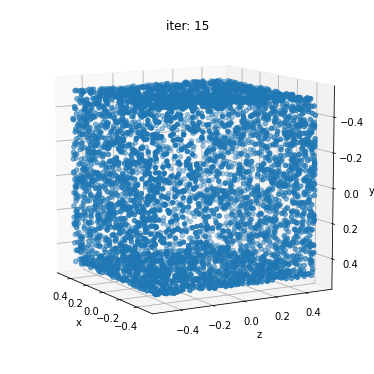

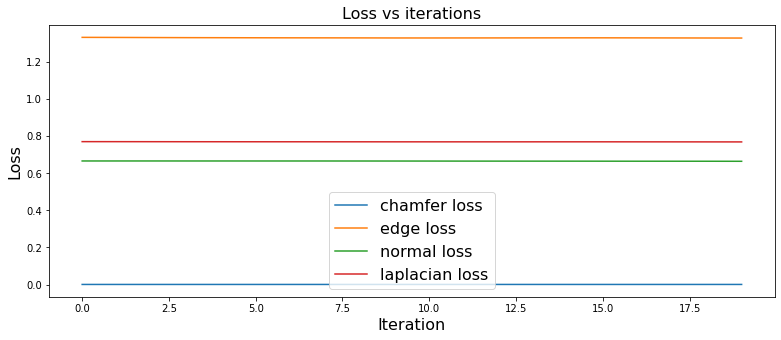

Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0
level 1 cubes


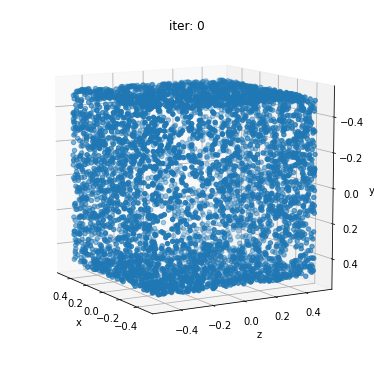

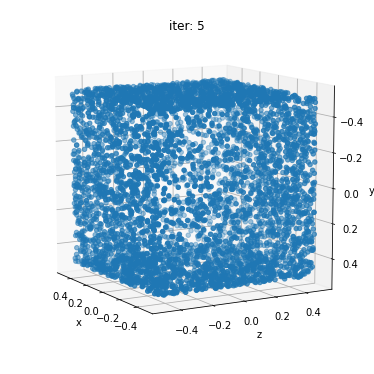

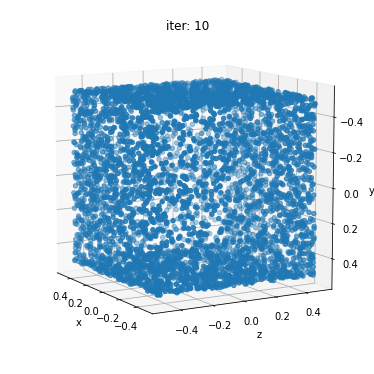

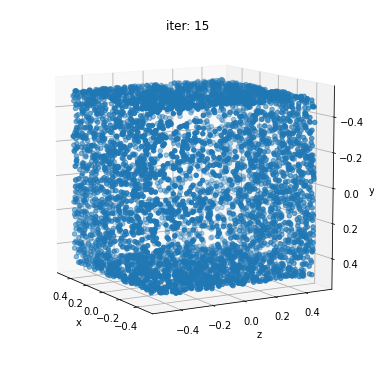

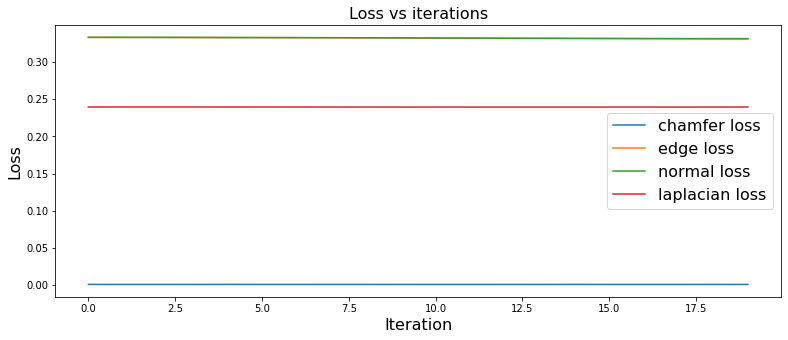

Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0
level 2 cubes


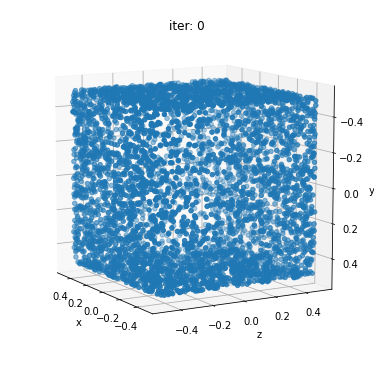

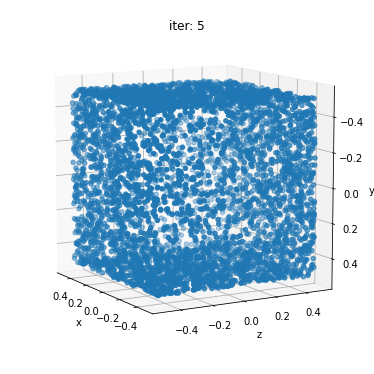

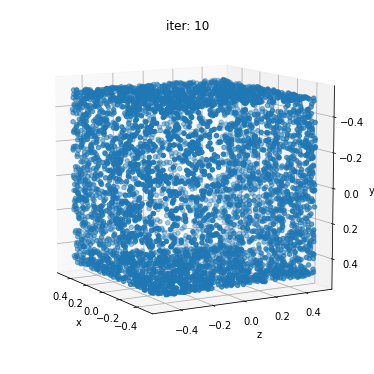

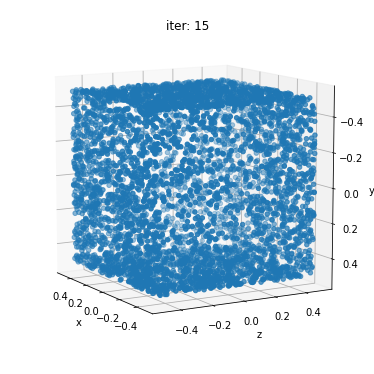

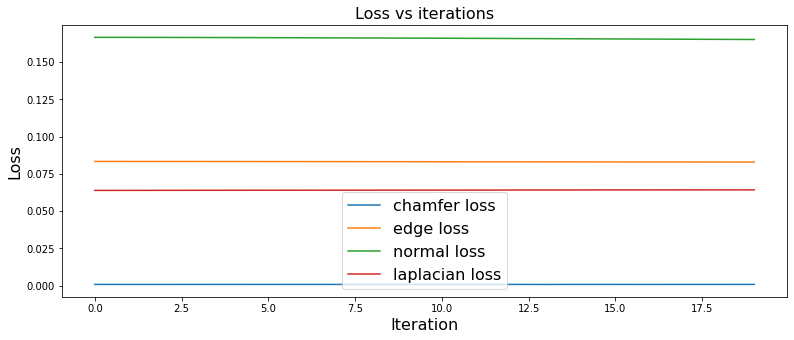

Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0
level 3 cubes


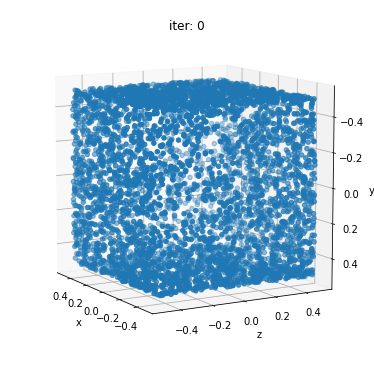

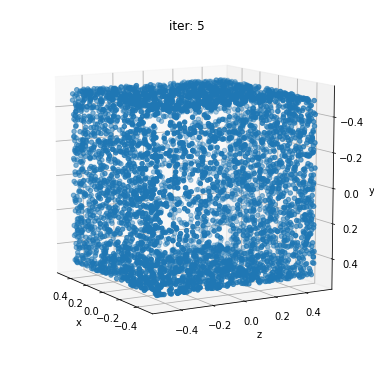

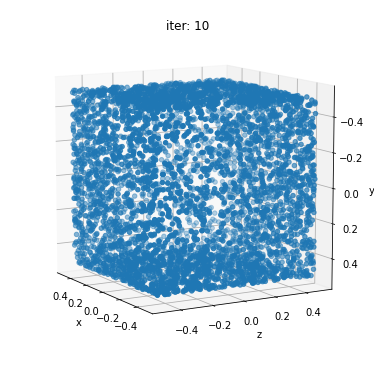

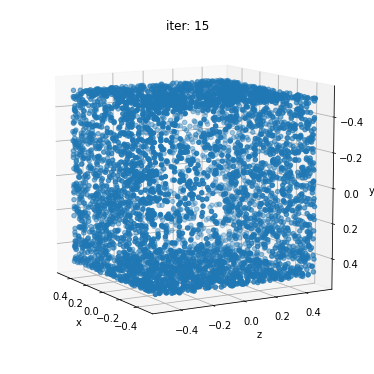

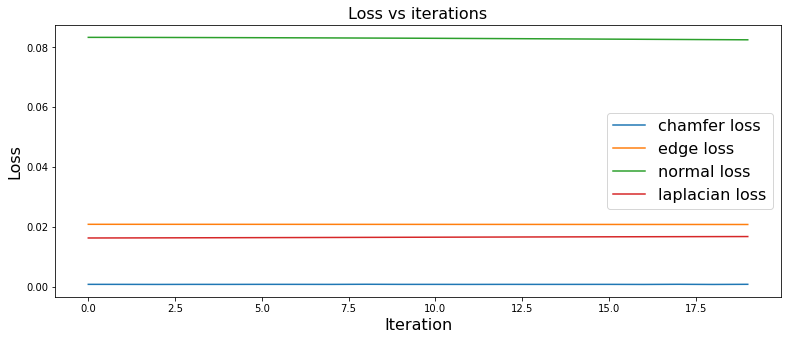

Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


In [15]:
for i, (source_mesh, target_mesh) in enumerate(pairs):
    print('level {} cubes'.format(i))
    optimized_mesh = deform_mesh(source_mesh, target_mesh, steps=20, plot_period=5)
    save_mesh(optimized_mesh, 'opt-cube-cube-lv{}.obj'.format(i))